In [48]:
import pandas as pd
import numpy as np
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

from sklearn import metrics
# from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [8]:
# load raw data
from google.colab import drive
drive.mount("Test_Problem")

Mounted at Test_Problem


In [9]:
#seting up the root DTR
Root_DTR ="drive/My Drive/Test_Problem/dataset/training.tsv"

In [10]:
import pandas as pd

In [11]:
Root_DTR ="Test_Problem/My Drive/Test_Problem/"

In [12]:
# Reading dataset and Giving proper column values according to the description
df_train =pd.read_csv(Root_DTR+'dataset/training.tsv',sep='\t',names=['User_id','Activity_date','Activity_type'])
df_test =pd.read_csv(Root_DTR+'dataset/test.tsv',sep='\t',names=['User_id','Activity_date','Activity_type'])

In [13]:
df_train

,User_id,Activity_date,Activity_type
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen
...,...,...,...
4918672,fffff031760c3f5,2014-06-24,EmailOpen
4918673,fffff031760c3f5,2014-06-25,EmailOpen
4918674,fffff031760c3f5,2014-07-02,EmailOpen
4918675,fffff031760c3f5,2014-08-11,EmailOpen


In [14]:
# Understanding the dataset better
# Getting the descriptive statstics parameters for the dataset

df_train.describe(include = 'all')

,User_id,Activity_date,Activity_type
count,4918677,4918677,4918677
unique,341568,671,7
top,2cd311cc3ef2d0c,2014-06-18,EmailOpen
freq,2718,50184,3191732


In [15]:
# Checking for missing values in the dataset

df_train.isnull().sum()

User_id          0
Activity_date    0
Activity_type    0
dtype: int64

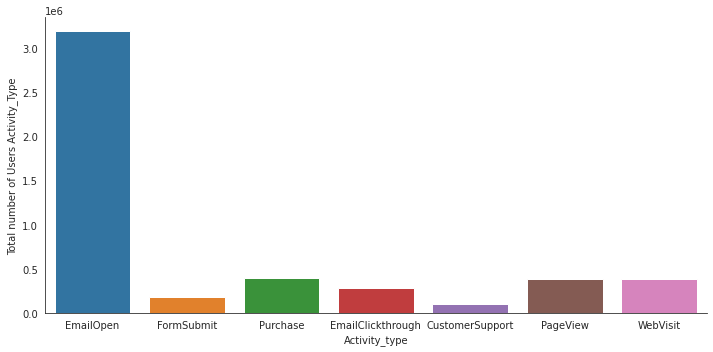

In [16]:
# Univariate Analysis to understand better the distribution of user activity across number of users
with sns.axes_style('white'):
    g = sns.factorplot("Activity_type", data=df_train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of Users Activity_Type")


In [17]:
df_train['Activity_type'] = df_train['Activity_type'].astype('category')

In [18]:
df_train['Activity_date'] = pd.to_datetime(df_train['Activity_date'])
date_range = str(df_train['Activity_date'].dt.date.min()) + ' to ' +str(df_train['Activity_date'].dt.date.max())

In [19]:
date_range

'2013-07-01 to 2015-05-02'

In [20]:
df_train.set_index('Activity_date')

,User_id,Activity_type
Activity_date,,
2013-07-11,00002acbe042d69,EmailOpen
2013-07-11,00002acbe042d69,FormSubmit
2013-07-15,00002acbe042d69,EmailOpen
2013-07-17,00002acbe042d69,EmailOpen
2013-07-18,00002acbe042d69,EmailOpen
...,...,...
2014-06-24,fffff031760c3f5,EmailOpen
2014-06-25,fffff031760c3f5,EmailOpen
2014-07-02,fffff031760c3f5,EmailOpen


In [21]:
funnel_steps = ["EmailOpen","EmailClickthrough", "FormSubmit", "WebVisit", "PageView", "CustomerSupport","Purchase"]

In [22]:
# Getting insights on user behaviour using Funnel Analysis

def funnelize(user_group, funnel_steps):
    user_freq = [0 for i in funnel_steps]
    
    for _,row in user_group.iterrows():
        activity = row['Activity_type']
        if activity in funnel_steps:
            idx = funnel_steps.index(activity)
            user_freq[idx] += 1
    return user_freq

In [23]:
grouped_data = df_train.groupby("User_id").apply(funnelize, funnel_steps)

In [24]:
user_to_activity = pd.DataFrame(list(grouped_data.values),index = grouped_data.index,columns = funnel_steps)

In [25]:
user_to_activity.head(10)

,EmailOpen,EmailClickthrough,FormSubmit,WebVisit,PageView,CustomerSupport,Purchase
User_id,,,,,,,
00002acbe042d69,9,0,1,0,0,0,0
0000a3a34bd07e6,20,0,0,0,0,0,0
0000ecf58c94668,11,1,1,0,0,1,6
00012205dd4613b,2,0,0,0,0,0,0
000198d39a568cf,0,0,0,0,0,1,1
0001b315b991cf0,1,0,0,0,0,0,0
00022618457fcf2,0,0,0,0,0,1,1
000256826de4432,0,0,0,0,0,1,1
000269150971d08,3,0,0,0,0,0,0


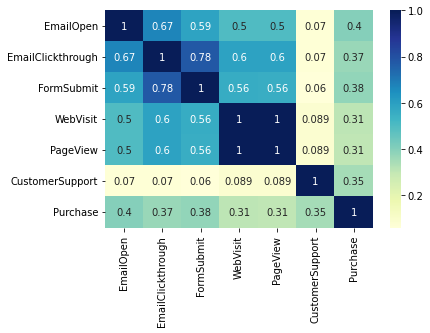

In [26]:
##Plotting correlation
corrMatrix = user_to_activity.corr()
dataplot = sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True)
plt.show()

In [146]:
# As we can see, WebVisit and PageView have high correlation value, it is better to remove one feature. This would reduce the
# dimentionality of the dataset and make our model coparitively faster.

user_to_activity = user_to_activity.drop(['WebVisit', 'CustomerSupport'], axis=1)

In [28]:
user_to_activity 

,EmailOpen,EmailClickthrough,FormSubmit,PageView,Purchase
User_id,,,,,
00002acbe042d69,9,0,1,0,0
0000a3a34bd07e6,20,0,0,0,0
0000ecf58c94668,11,1,1,0,6
00012205dd4613b,2,0,0,0,0
000198d39a568cf,0,0,0,0,1
...,...,...,...,...,...
ffffa46241fb077,0,0,0,0,2
ffffa4cc0190881,1,0,0,0,0
ffffa7beb541707,2,0,1,0,0


In [29]:
user_to_activity["Purchased?"] = np.where(user_to_activity["Purchase"] >= 1, 1, 0)

In [30]:
user_to_activity

,EmailOpen,EmailClickthrough,FormSubmit,PageView,Purchase,Purchased?
User_id,,,,,,
00002acbe042d69,9,0,1,0,0,0
0000a3a34bd07e6,20,0,0,0,0,0
0000ecf58c94668,11,1,1,0,6,1
00012205dd4613b,2,0,0,0,0,0
000198d39a568cf,0,0,0,0,1,1
...,...,...,...,...,...,...
ffffa46241fb077,0,0,0,0,2,1
ffffa4cc0190881,1,0,0,0,0,0
ffffa7beb541707,2,0,1,0,0,0


In [148]:
train = user_to_activity.sample(frac = 0.7)

In [151]:
test = user_to_activity.loc[~user_to_activity.index.isin(df_train.index)]

In [152]:
train = train.to_numpy()
test = test.to_numpy()

In [153]:
X_train = train[:,:-2]

In [154]:
Y_train = train[:,-1]

In [155]:
X_test = test[:,:-2]

In [156]:
Y_test = test[:,-1]

In [157]:
model = LogisticRegression()

In [158]:
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [159]:
predicted = model.predict(X_test)

In [160]:
print(metrics.classification_report(Y_test, predicted))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82    237577
           1       0.74      0.02      0.04    103991

    accuracy                           0.70    341568
   macro avg       0.72      0.51      0.43    341568
weighted avg       0.71      0.70      0.59    341568



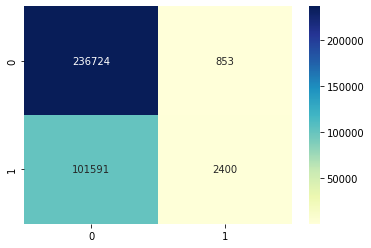

In [161]:

cf_matrix = metrics.confusion_matrix(Y_test, predicted)
sns.heatmap(cf_matrix,  cmap="YlGnBu", annot=True, fmt='g')

In [162]:
# Random Forest Approach
user_to_activity = pd.DataFrame(list(grouped_data.values),index = grouped_data.index,columns = funnel_steps)

In [163]:
user_to_activity = user_to_activity.drop(['CustomerSupport'], axis=1)

In [164]:
user_to_activity["Purchased?"] = np.where(user_to_activity["Purchase"] >= 1, 1, 0)

In [166]:
train = user_to_activity.sample(frac = 0.7)
test = user_to_activity.loc[~user_to_activity.index.isin(df_train.index)]
user_to_activity

,EmailOpen,EmailClickthrough,FormSubmit,WebVisit,PageView,Purchase,Purchased?
User_id,,,,,,,
00002acbe042d69,9,0,1,0,0,0,0
0000a3a34bd07e6,20,0,0,0,0,0,0
0000ecf58c94668,11,1,1,0,0,6,1
00012205dd4613b,2,0,0,0,0,0,0
000198d39a568cf,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...
ffffa46241fb077,0,0,0,0,0,2,1
ffffa4cc0190881,1,0,0,0,0,0,0
ffffa7beb541707,2,0,1,0,0,0,0


In [167]:
train = train.to_numpy()
test = test.to_numpy()

X_train = train[:,:-2]
Y_train = train[:,-1]

X_test = test[:,:-2]
Y_test = test[:,-1]

In [168]:
forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(X_train, Y_train)

In [169]:
rf_predicted = forest.predict(X_test)

In [170]:
rf_predicted.shape

(341568,)

In [171]:
print(metrics.classification_report(Y_test, rf_predicted))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    237577
           1       0.97      0.72      0.82    103991

    accuracy                           0.91    341568
   macro avg       0.93      0.85      0.88    341568
weighted avg       0.91      0.91      0.90    341568



In [172]:
feature_importance = forest.feature_importances_

In [173]:
feature_importance

array([0.68748505, 0.08029467, 0.17140838, 0.0326322 , 0.0281797 ])

In [174]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(feature_importance)[::-1]

In [175]:
print("Feature ranking:")
features = ['EmailOpen','EmailClickthrough', 'FormSubmit', 'WebVisit', 'PageView']
for f in range(X_train.shape[1]):
#     print("%d. feature {} (%f)" % (f + 1 , features[f], feature_importance[indices[f]]))
    print("{0}. {1} = {2}".format(f  + 1, features[f], round(feature_importance[indices[f]], 2)))

Feature ranking:
1. EmailOpen = 0.69
2. EmailClickthrough = 0.17
3. FormSubmit = 0.08
4. WebVisit = 0.03
5. PageView = 0.03


In [176]:
df_test =pd.read_csv(Root_DTR+'dataset/test.tsv',sep='\t',names=['User_id','Activity_date','Activity_type'])

In [177]:
df_test.columns = ['User_id','Activity_date','Activity_type']

In [178]:
df_test.sort_values(by="Activity_date",ascending=True, inplace=True)

In [179]:
df_test

,User_id,Activity_date,Activity_type
687866,d419eae525d4301,2015-05-01,EmailOpen
339539,5d7c05e8f37b353,2015-05-01,EmailOpen
608390,b6de84cb47e7826,2015-05-01,EmailOpen
226398,3c2f9fd36293bc7,2015-05-01,WebVisit
226397,3c2f9fd36293bc7,2015-05-01,PageView
...,...,...,...
296590,50c39c3bfaf98a5,2015-07-31,EmailOpen
296637,50c6ac0d3256c47,2015-07-31,EmailOpen
57088,0dedb7bfe7e2c52,2015-07-31,FormSubmit
57090,0dedb7bfe7e2c52,2015-07-31,WebVisit


In [181]:
test_activities = df_test["Activity_type"].unique()
test_activities

array(['EmailOpen', 'WebVisit', 'PageView', 'EmailClickthrough',
       'FormSubmit'], dtype=object)

In [182]:
activity_steps_test = ['EmailOpen', 'WebVisit', 'PageView', 'EmailClickthrough', 'FormSubmit']

In [184]:
grouped_test = df_test.groupby("User_id").apply(funnelize, activity_steps_test)

In [185]:
user_to_activity_test = pd.DataFrame(list(grouped_test.values),index = grouped_test.index,columns = activity_steps_test)

In [186]:
user_to_activity_test

,EmailOpen,WebVisit,PageView,EmailClickthrough,FormSubmit
User_id,,,,,
0000ecf58c94668,5,0,0,0,0
000132f21724ee2,1,0,0,1,0
0001b315b991cf0,3,0,0,0,0
000269150971d08,4,0,0,0,0
000297ba4fa5026,3,0,0,0,0
...,...,...,...,...,...
fffc7f2ad169c6b,1,0,0,0,0
fffd77a0266d37c,3,1,1,0,1
fffed482b52afd8,1,0,0,0,0


In [187]:
user_to_activity_test_arr = user_to_activity_test.to_numpy()

In [188]:
user_to_activity_test_arr.shape

(132810, 5)

In [189]:
predicted_test = forest.predict(user_to_activity_test_arr)

In [190]:
output = forest.predict_proba(user_to_activity_test_arr)

In [191]:
output = pd.DataFrame(output)

In [192]:
output

,0,1
0,0.900894,0.099106
1,0.953183,0.046817
2,0.918359,0.081641
3,0.910478,0.089522
4,0.918359,0.081641
...,...,...
132805,0.939324,0.060676
132806,0.900246,0.099754
132807,0.939324,0.060676
132808,0.939324,0.060676


In [193]:
user_to_activity_test['User_ID'] = user_to_activity_test.index

In [194]:
user_to_activity_test.index = range(132810)
output.index = range(132810)

In [195]:
output_with_activities = pd.concat([user_to_activity_test, output], axis = 1)

In [196]:
output_with_activities

,EmailOpen,WebVisit,PageView,EmailClickthrough,FormSubmit,User_ID,0,1
0,5,0,0,0,0,0000ecf58c94668,0.900894,0.099106
1,1,0,0,1,0,000132f21724ee2,0.953183,0.046817
2,3,0,0,0,0,0001b315b991cf0,0.918359,0.081641
3,4,0,0,0,0,000269150971d08,0.910478,0.089522
4,3,0,0,0,0,000297ba4fa5026,0.918359,0.081641
...,...,...,...,...,...,...,...,...
132805,1,0,0,0,0,fffc7f2ad169c6b,0.939324,0.060676
132806,3,1,1,0,1,fffd77a0266d37c,0.900246,0.099754
132807,1,0,0,0,0,fffed482b52afd8,0.939324,0.060676
132808,1,0,0,0,0,ffffa4cc0190881,0.939324,0.060676


In [197]:
output_with_activities.columns = ['EmailOpen','WebVisit','PageView','EmailClickthrough', 'FormSubmit', 'User_ID', 'noPurchase','willPurchase']

In [198]:
output_with_activities

,EmailOpen,WebVisit,PageView,EmailClickthrough,FormSubmit,User_ID,noPurchase,willPurchase
0,5,0,0,0,0,0000ecf58c94668,0.900894,0.099106
1,1,0,0,1,0,000132f21724ee2,0.953183,0.046817
2,3,0,0,0,0,0001b315b991cf0,0.918359,0.081641
3,4,0,0,0,0,000269150971d08,0.910478,0.089522
4,3,0,0,0,0,000297ba4fa5026,0.918359,0.081641
...,...,...,...,...,...,...,...,...
132805,1,0,0,0,0,fffc7f2ad169c6b,0.939324,0.060676
132806,3,1,1,0,1,fffd77a0266d37c,0.900246,0.099754
132807,1,0,0,0,0,fffed482b52afd8,0.939324,0.060676
132808,1,0,0,0,0,ffffa4cc0190881,0.939324,0.060676


In [199]:
potential_buyers = output_with_activities.sort_values(by = 'willPurchase', ascending = False)

In [200]:
top1000_users = potential_buyers.nlargest(1000, 'willPurchase')

In [201]:
top1000_users = top1000_users[['User_ID','willPurchase']]

In [202]:
top1000_users

,User_ID,willPurchase
41501,45b840cab790e95,0.994000
110108,cce95d60472c620,0.994000
75276,85318486d507f7d,0.994000
42229,4708979d4ea1c79,0.990000
46684,4ef8fad8fe024f9,0.990000
...,...,...
101747,bb2db0a93772426,0.700277
57910,63adffa00da294d,0.700000
55232,5eb75f40e179f55,0.700000
86686,9c0b1cb28c18c96,0.700000


In [225]:
top1000_users.to_csv('/drive/My Drive/Problem/dataset/Top_1000_rf.csv',index=False)

In [218]:
drive.mount("/drive")

Mounted at /drive


In [ ]:
submission.to_csv('/drive/My Drive/Problem/dataset/sample_submission_1.csv',index=False)

In [204]:
# Using Neural Network

mlp = MLPClassifier(hidden_layer_sizes=(5,8,8), activation='relu', solver='adam', max_iter=1000)

In [205]:
mlp.fit(X_train,Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 8, 8), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [206]:
predict_test = mlp.predict(X_test)

In [207]:

nn_cf_matrix_test = metrics.confusion_matrix(Y_test,predict_test)

In [216]:
nn_cf_matrix_test

array([[235099,   2478],
       [ 34696,  69295]])

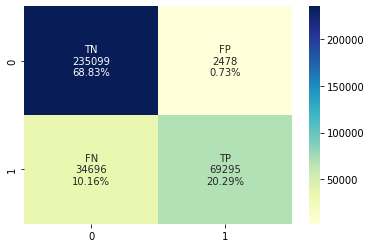

In [217]:
group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in
                nn_cf_matrix_test.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     nn_cf_matrix_test.flatten()/np.sum(nn_cf_matrix_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(nn_cf_matrix_test, cmap="YlGnBu", annot=labels, fmt='')

In [211]:
print(metrics.classification_report(Y_test,predict_test))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    237577
           1       0.97      0.67      0.79    103991

    accuracy                           0.89    341568
   macro avg       0.92      0.83      0.86    341568
weighted avg       0.90      0.89      0.88    341568

